导入数据

In [1]:
import numpy as np
import pandas as pd
train=pd.read_csv('./input/train.tsv', sep='\t')
test=pd.read_csv('./input/test.tsv', sep='\t')

预处理和分词

In [3]:
from nltk.stem import WordNetLemmatizer
import re
lemmatizer = WordNetLemmatizer() 
def clean_data(text):
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", " ",text)
    text = re.sub("-"," ",text)
    tokens = text.lower().split()
    return tokens
train_data = train['Phrase'].apply(clean_data)
test_data = test['Phrase'].apply(clean_data)

构建词表

In [4]:
vocab=[]
vocab.append('')
for text in train_data:
    for word in text:
        vocab.append(word)
for text in test_data:
    for word in text:
        vocab.append(word)
vocab=set(vocab)
word_to_idx = {word: i+1 for i, word in enumerate(vocab)}
word_to_idx['<unk>'] = 0
idx_to_word = {i+1: word for i, word in enumerate(vocab)}
idx_to_word[0] = '<unk>'

In [5]:
len(vocab)

17820

文本序列化

In [6]:
max_len = 50
X_train = np.zeros((len(train_data),max_len)).astype(int)
X_test = np.zeros((len(test_data),max_len)).astype(int)
for i in range(0,len(train_data)):
    if len(train_data[i])<max_len:
        for j in range(0,len(train_data[i])):
            X_train[i][j]=word_to_idx[train_data[i][j]]
        for j in range(len(train_data[i]),max_len):
            X_train[i][j] = word_to_idx['<unk>']
    else:
        for j in range(0,max_len):
            X_train[i][j]=word_to_idx[train_data[i][j]]
            
for i in range(0,len(test_data)):
    if len(test_data[i])<max_len:
        for j in range(0,len(test_data[i])):
            X_test[i][j]=word_to_idx[test_data[i][j]]
        for j in range(len(test_data[i]),max_len):
            X_test[i][j] = word_to_idx['<unk>']
    else:
        for j in range(0,max_len):
            X_test[i][j]=word_to_idx[test_data[i][j]]

划分训练集，验证集，划分batch，生成训练数据

In [7]:
import torch
from torch.utils.data import Dataset,DataLoader,TensorDataset
y_train = np.array(train['Sentiment'])
train_set = TensorDataset(torch.from_numpy(X_train).long(),torch.from_numpy(y_train).long())
train_set, val_set = torch.utils.data.random_split(train_set, [130000, 26060])
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
val_loader = DataLoader(val_set, batch_size=256, shuffle=True)
test_loader = DataLoader(torch.from_numpy(X_train).long())

加载词向量

In [8]:
import gensim
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
# 已有的glove词向量
glove_file = datapath('E:/Jupyter/FDUNLP_task/input/glove.twitter.27B.50d.txt')
# 指定转化为word2vec格式后文件的位置
tmp_file = get_tmpfile("E:/Jupyter/FDUNLP_task/input/test_word2vec.txt")
from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec(glove_file, tmp_file)
wvmodel = gensim.models.KeyedVectors.load_word2vec_format('./input/test_word2vec.txt', binary=False, encoding='utf-8')
vocab_size = len(vocab) + 1
embed_size = 50
weight = np.zeros((vocab_size, embed_size))
for word in vocab:
    if word in wvmodel.vocab:
        weight[word_to_idx[word],:] = wvmodel[word]
weight = torch.from_numpy(weight)

### CNN

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TextCNN(nn.Module):
    def __init__(self, vocab_size,embedding_dim, kernel_sizes, num_filters, num_classes, embedding_matrix=None,freeze=False):
        super(TextCNN, self).__init__()
        #嵌入层
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
        if embedding_matrix is not None:
            #加载词向量
            self.embedding.weight.data.copy_(embedding_matrix)
            if freeze is True:
                self.embedding.weight.data.requires_grad = False
        self.conv = nn.ModuleList([nn.Conv1d(in_channels=embedding_dim,
                                 out_channels=num_filters,
                                 kernel_size=k, stride=1) for k in kernel_sizes])
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)

    def forward(self, x):
        batch_size, sequence_length = x.shape
        x = self.embedding(x).transpose(1, 2)
        x = [F.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, c.size(-1)).squeeze(dim=-1) for c in x]
        x = torch.cat(x, dim=1)
        x = self.fc(self.dropout(x))
        return torch.sigmoid(x).squeeze()

In [12]:
vocab_size = 17821
embedding_dim = 50
kernel_sizes = [3,4,5]

epoch: 0, Train Loss: 1.350439, Train Acc: 0.508516, Eval Loss: 1.329323, Eval Acc: 0.515714
epoch: 1, Train Loss: 1.315706, Train Acc: 0.510997, Eval Loss: 1.297687, Eval Acc: 0.517271
epoch: 2, Train Loss: 1.286197, Train Acc: 0.517120, Eval Loss: 1.278250, Eval Acc: 0.525848
epoch: 3, Train Loss: 1.266951, Train Acc: 0.525455, Eval Loss: 1.267476, Eval Acc: 0.526043
epoch: 4, Train Loss: 1.254020, Train Acc: 0.537227, Eval Loss: 1.259673, Eval Acc: 0.541104
epoch: 5, Train Loss: 1.244777, Train Acc: 0.545152, Eval Loss: 1.255942, Eval Acc: 0.538967
epoch: 6, Train Loss: 1.238079, Train Acc: 0.552082, Eval Loss: 1.252488, Eval Acc: 0.549548
epoch: 7, Train Loss: 1.232680, Train Acc: 0.557013, Eval Loss: 1.249647, Eval Acc: 0.554191
epoch: 8, Train Loss: 1.228560, Train Acc: 0.562256, Eval Loss: 1.247363, Eval Acc: 0.563787
epoch: 9, Train Loss: 1.224814, Train Acc: 0.569015, Eval Loss: 1.246483, Eval Acc: 0.562691
epoch: 10, Train Loss: 1.221897, Train Acc: 0.570675, Eval Loss: 1.245

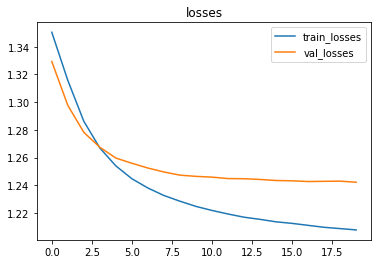

In [13]:
from trainer import run
import matplotlib.pyplot as plt
%matplotlib inline
model1 = TextCNN(vocab_size, embedding_dim,kernel_sizes,100,5)
train_losses, val_losses = run(model1,train_loader,val_loader,20,1e-3,'./cnn/cnn_bst.pth')
plt.title('losses')
plt.plot(np.arange(len(train_losses)), train_losses,label='train_losses')
plt.plot(np.arange(len(val_losses)), val_losses,label='val_losses')
plt.legend()
plt.show()

In [14]:
model1.load_state_dict(torch.load('./cnn/cnn_bst.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [15]:
from trainer import predict
test_predictions = predict(model1,torch.from_numpy(X_test).long())

In [16]:
output = pd.DataFrame({
    'PhraseId': test['PhraseId'],
    'Sentiment': test_predictions
})

output.to_csv('cnn_submission.csv', index=False)

得分为0.55952

### CNN(pretrained)

#### 冻结嵌入层参数

In [17]:
embedding_dim = 50
kernel_sizes = [3,4,5]

epoch: 0, Train Loss: 1.309964, Train Acc: 0.507686, Eval Loss: 1.260547, Eval Acc: 0.517762
epoch: 1, Train Loss: 1.253859, Train Acc: 0.520252, Eval Loss: 1.245695, Eval Acc: 0.531501
epoch: 2, Train Loss: 1.236804, Train Acc: 0.535909, Eval Loss: 1.239702, Eval Acc: 0.544013
epoch: 3, Train Loss: 1.227233, Train Acc: 0.549951, Eval Loss: 1.236485, Eval Acc: 0.554940
epoch: 4, Train Loss: 1.221198, Train Acc: 0.559657, Eval Loss: 1.235064, Eval Acc: 0.562580
epoch: 5, Train Loss: 1.216327, Train Acc: 0.568129, Eval Loss: 1.234772, Eval Acc: 0.571090
epoch: 6, Train Loss: 1.212789, Train Acc: 0.575157, Eval Loss: 1.233761, Eval Acc: 0.574211
epoch: 7, Train Loss: 1.210277, Train Acc: 0.578614, Eval Loss: 1.233689, Eval Acc: 0.580198
epoch: 8, Train Loss: 1.207688, Train Acc: 0.583409, Eval Loss: 1.233078, Eval Acc: 0.576808
epoch: 9, Train Loss: 1.205684, Train Acc: 0.584306, Eval Loss: 1.233121, Eval Acc: 0.583376
epoch: 10, Train Loss: 1.203981, Train Acc: 0.588028, Eval Loss: 1.233

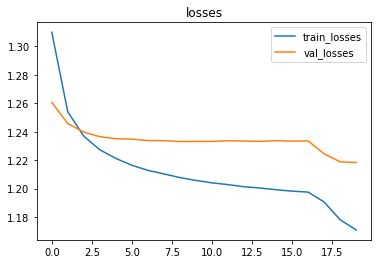

In [18]:
from trainer import run
import matplotlib.pyplot as plt
%matplotlib inline
model2 = TextCNN(vocab_size, embedding_dim,kernel_sizes,100,5, weight,freeze=True)
train_losses, val_losses = run(model2,train_loader,val_loader,20,1e-3,'./cnn/cnn_pretrained_freeze.pth')
plt.title('losses')
plt.plot(np.arange(len(train_losses)), train_losses,label='train_losses')
plt.plot(np.arange(len(val_losses)), val_losses,label='val_losses')
plt.legend()
plt.show()

In [21]:
model2.load_state_dict(torch.load('./cnn/cnn_pretrained_freeze.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [22]:
from trainer import predict
test_predictions = predict(model2,torch.from_numpy(X_test).long())

In [24]:
output = pd.DataFrame({
    'PhraseId': test['PhraseId'],
    'Sentiment': test_predictions
})

output.to_csv('cnn_freeze_submission.csv', index=False)

In [15]:
embedding_dim = 50
kernel_sizes = [3,4,5]

得分：0.61757

#### 不冻结嵌入层参数

epoch: 0, Train Loss: 1.310255, Train Acc: 0.506540, Eval Loss: 1.259689, Eval Acc: 0.516958
epoch: 1, Train Loss: 1.253785, Train Acc: 0.520141, Eval Loss: 1.246058, Eval Acc: 0.531710
epoch: 2, Train Loss: 1.237280, Train Acc: 0.538763, Eval Loss: 1.240421, Eval Acc: 0.548848
epoch: 3, Train Loss: 1.227500, Train Acc: 0.552885, Eval Loss: 1.238292, Eval Acc: 0.561365
epoch: 4, Train Loss: 1.220941, Train Acc: 0.563071, Eval Loss: 1.235441, Eval Acc: 0.569031
epoch: 5, Train Loss: 1.216404, Train Acc: 0.570036, Eval Loss: 1.234289, Eval Acc: 0.568850
epoch: 6, Train Loss: 1.212828, Train Acc: 0.576579, Eval Loss: 1.234016, Eval Acc: 0.581534
epoch: 7, Train Loss: 1.209977, Train Acc: 0.581967, Eval Loss: 1.233380, Eval Acc: 0.575466
epoch: 8, Train Loss: 1.207491, Train Acc: 0.586037, Eval Loss: 1.233144, Eval Acc: 0.582696
epoch: 9, Train Loss: 1.205842, Train Acc: 0.589513, Eval Loss: 1.232429, Eval Acc: 0.584564
epoch: 10, Train Loss: 1.203899, Train Acc: 0.591016, Eval Loss: 1.231

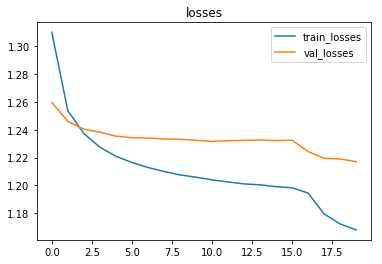

In [20]:
from trainer import run
import matplotlib.pyplot as plt
%matplotlib inline
model3 = TextCNN(vocab_size, embedding_dim,kernel_sizes,100,5, weight)
train_losses, val_losses = run(model3,train_loader,val_loader,20,1e-3,'./cnn/cnn_pretrained.pth')
plt.title('losses')
plt.plot(np.arange(len(train_losses)), train_losses,label='train_losses')
plt.plot(np.arange(len(val_losses)), val_losses,label='val_losses')
plt.legend()
plt.show()

In [40]:
model3.load_state_dict(torch.load('./cnn/cnn_pretrained.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [41]:
from trainer import predict
test_predictions = predict(model3,torch.from_numpy(X_test).long())

In [42]:
output = pd.DataFrame({
    'PhraseId': test['PhraseId'],
    'Sentiment': test_predictions
})

output.to_csv('cnn_pretrained_submission.csv', index=False)

得分：0.61764

### RNN

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, vocab_size,embedding_dim, hidden_state, num_classes, embedding_matrix=None,freeze=False):
        super(RNN, self).__init__()
        #嵌入层
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
        if embedding_matrix is not None:
            #加载词向量
            self.embedding.weight.data.copy_(embedding_matrix)
            if freeze is True: 
                self.embedding.weight.data.requires_grad = False
        self.rnn = nn.GRU(embedding_dim,hidden_state,2,batch_first = True)
        self.fc = nn.Linear(hidden_state, num_classes)

    def forward(self, x):
        embed = self.embedding(x) 
        out,_= self.rnn(embed)
        out = self.fc(out[:,-1,:])
        return out

In [23]:
vocab_size = 17821
embedding_dim = 50
model4 = RNN(vocab_size, embedding_dim,50,5)

epoch: 0, Train Loss: 1.217224, Train Acc: 0.516395, Eval Loss: 1.160766, Eval Acc: 0.533395
epoch: 1, Train Loss: 1.054992, Train Acc: 0.578065, Eval Loss: 0.983011, Eval Acc: 0.607905
epoch: 2, Train Loss: 0.906758, Train Acc: 0.635863, Eval Loss: 0.909062, Eval Acc: 0.633622
epoch: 3, Train Loss: 0.827969, Train Acc: 0.665935, Eval Loss: 0.871132, Eval Acc: 0.645944
epoch: 4, Train Loss: 0.777222, Train Acc: 0.684885, Eval Loss: 0.853992, Eval Acc: 0.657397
epoch: 5, Train Loss: 0.739848, Train Acc: 0.699872, Eval Loss: 0.839896, Eval Acc: 0.658783
epoch: 6, Train Loss: 0.707699, Train Acc: 0.712048, Eval Loss: 0.835413, Eval Acc: 0.660048
epoch: 7, Train Loss: 0.682666, Train Acc: 0.723054, Eval Loss: 0.826821, Eval Acc: 0.668223
epoch: 8, Train Loss: 0.660276, Train Acc: 0.731682, Eval Loss: 0.834611, Eval Acc: 0.667984
epoch: 9, Train Loss: 0.641330, Train Acc: 0.738949, Eval Loss: 0.835254, Eval Acc: 0.667774
epoch: 10, Train Loss: 0.624196, Train Acc: 0.747833, Eval Loss: 0.851

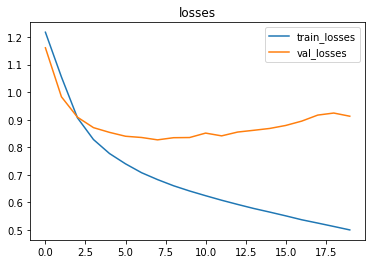

In [24]:
from trainer import run
import matplotlib.pyplot as plt
%matplotlib inline
train_losses, val_losses = run(model4,train_loader,val_loader,20,1e-3,'./rnn/rnn_bst.pth')
plt.title('losses')
plt.plot(np.arange(len(train_losses)), train_losses,label='train_losses')
plt.plot(np.arange(len(val_losses)), val_losses,label='val_losses')
plt.legend()
plt.show()

In [25]:
model4.load_state_dict(torch.load('./rnn/rnn_bst.pth'))

In [26]:
from trainer import predict
test_predictions = predict(model3,torch.from_numpy(X_test).long())

In [27]:
output = pd.DataFrame({
    'PhraseId': test['PhraseId'],
    'Sentiment': test_predictions
})

output.to_csv('rnn_submission.csv', index=False)

测试集得分为0.61087

### RNN(pretrained)

In [31]:
vocab_size = 17821
embedding_dim = 50
model5 = RNN(vocab_size, embedding_dim,50,5,weight,freeze=True)

epoch: 0, Train Loss: 1.134233, Train Acc: 0.547464, Eval Loss: 0.931062, Eval Acc: 0.620694
epoch: 1, Train Loss: 0.859171, Train Acc: 0.649028, Eval Loss: 0.833508, Eval Acc: 0.657165
epoch: 2, Train Loss: 0.771418, Train Acc: 0.682722, Eval Loss: 0.812877, Eval Acc: 0.664653
epoch: 3, Train Loss: 0.723156, Train Acc: 0.700543, Eval Loss: 0.804293, Eval Acc: 0.666050
epoch: 4, Train Loss: 0.690429, Train Acc: 0.714615, Eval Loss: 0.798527, Eval Acc: 0.669612
epoch: 5, Train Loss: 0.664908, Train Acc: 0.724054, Eval Loss: 0.801077, Eval Acc: 0.672754
epoch: 6, Train Loss: 0.643309, Train Acc: 0.732218, Eval Loss: 0.811239, Eval Acc: 0.671489
epoch: 7, Train Loss: 0.625673, Train Acc: 0.739585, Eval Loss: 0.806382, Eval Acc: 0.671545
epoch: 8, Train Loss: 0.609355, Train Acc: 0.746772, Eval Loss: 0.822408, Eval Acc: 0.672112
epoch: 9, Train Loss: 0.593421, Train Acc: 0.752477, Eval Loss: 0.836984, Eval Acc: 0.671011
epoch: 10, Train Loss: 0.579175, Train Acc: 0.759048, Eval Loss: 0.842

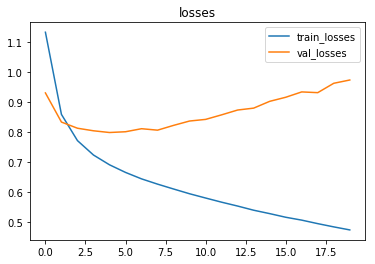

In [32]:
from trainer import run
import matplotlib.pyplot as plt
%matplotlib inline
train_losses, val_losses = run(model5,train_loader,val_loader,20,1e-3,'./rnn/rnn_pretrained_freeze.pth')
plt.title('losses')
plt.plot(np.arange(len(train_losses)), train_losses,label='train_losses')
plt.plot(np.arange(len(val_losses)), val_losses,label='val_losses')
plt.legend()
plt.show()

In [43]:
model5.load_state_dict(torch.load('./rnn/rnn_pretrained_freeze.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [44]:
from trainer import predict
test_predictions = predict(model5,torch.from_numpy(X_test).long())

In [45]:
output = pd.DataFrame({
    'PhraseId': test['PhraseId'],
    'Sentiment': test_predictions
})

output.to_csv('rnn_freeze_submission.csv', index=False)

得分为：0.64196

epoch: 0, Train Loss: 1.121513, Train Acc: 0.552782, Eval Loss: 0.912485, Eval Acc: 0.626738
epoch: 1, Train Loss: 0.850599, Train Acc: 0.651069, Eval Loss: 0.837459, Eval Acc: 0.655299
epoch: 2, Train Loss: 0.768745, Train Acc: 0.682168, Eval Loss: 0.809989, Eval Acc: 0.666710
epoch: 3, Train Loss: 0.722694, Train Acc: 0.699429, Eval Loss: 0.796308, Eval Acc: 0.671988
epoch: 4, Train Loss: 0.690691, Train Acc: 0.712992, Eval Loss: 0.797698, Eval Acc: 0.672820
epoch: 5, Train Loss: 0.667553, Train Acc: 0.721483, Eval Loss: 0.793001, Eval Acc: 0.677569
epoch: 6, Train Loss: 0.645984, Train Acc: 0.730479, Eval Loss: 0.800333, Eval Acc: 0.675298
epoch: 7, Train Loss: 0.628507, Train Acc: 0.737497, Eval Loss: 0.801060, Eval Acc: 0.676104
epoch: 8, Train Loss: 0.612791, Train Acc: 0.743940, Eval Loss: 0.817608, Eval Acc: 0.673941
epoch: 9, Train Loss: 0.597852, Train Acc: 0.748547, Eval Loss: 0.827647, Eval Acc: 0.676438
epoch: 10, Train Loss: 0.584047, Train Acc: 0.755633, Eval Loss: 0.830

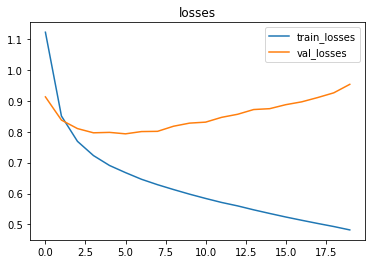

In [33]:
model6 = RNN(vocab_size, embedding_dim,50,5,weight,freeze=True)
from trainer import run
import matplotlib.pyplot as plt
%matplotlib inline
train_losses, val_losses = run(model6,train_loader,val_loader,20,1e-3,'./rnn/rnn_pretrained_freeze.pth')
plt.title('losses')
plt.plot(np.arange(len(train_losses)), train_losses,label='train_losses')
plt.plot(np.arange(len(val_losses)), val_losses,label='val_losses')
plt.legend()
plt.show()

In [34]:
model6.load_state_dict(torch.load('./rnn/rnn_pretrained_bst.pth'))

In [35]:
from trainer import predict
test_predictions = predict(model6,torch.from_numpy(X_test).long())

In [36]:
output = pd.DataFrame({
    'PhraseId': test['PhraseId'],
    'Sentiment': test_predictions
})

output.to_csv('rnn_pretrained_submission.csv', index=False)

得分为0.64226